# Capstone Two - 5 Extended Modeling: PMDARIMA<a id='5'></a>

## 5.1 Contents<a id='5.1'></a>
* [5 Extended Modeling](#5)
  * [5.1 Contents](#5.1)
  * [5.2 Imports](#5.2)
  * [5.3 Load The Data](#5.3)
  * [5.4 Data Processing](#5.4)
  * [5.5 Modeling](#5.5)
    * [5.5.1 Apply pm.auto_arima() for single timeseries](#5.5.1)
    * [5.5.2 Apply pm.auto_arima() for multiple timeseries](#5.5.2)
  * [5.6 Evaluation](#5.6)
    * [5.6.1 MAPE](#5.6.1)
    * [5.6.2 Scatter plots](#5.6.2)
    * [5.6.3 Distribution of residuals](#5.6.3)
  * [5.7 Save Data](#5.7) 
    

## 5.2 Imports<a id='5.2'></a>

In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
from library.sb_utils import save_file

In [2]:
import pmdarima as pm
from pmdarima.model_selection import train_test_split
# pm.show_versions()

## 5.3 Load The Data<a id='5.3'></a>

In [3]:
data_dir = '../data/'

data_ori = pd.read_csv(data_dir+'train_all_groups.csv')
data_ori.head(3)

,date,store_nbr,family,sales,onpromotion,city,state,store_type,cluster,dcoilwtico,transactions,holiday_type,transferred,year,month
0,2013-01-01,1,AUTOMOTIVE,0.0,0,Quito,Pichincha,D,13,93.14,0.0,Holiday,False,2013,1
1,2013-01-01,1,BABY CARE,0.0,0,Quito,Pichincha,D,13,93.14,0.0,Holiday,False,2013,1
2,2013-01-01,1,BEAUTY,0.0,0,Quito,Pichincha,D,13,93.14,0.0,Holiday,False,2013,1


In [4]:
data = data_ori[['date', 'store_nbr', 'family', 'sales']]
data.set_index('date', inplace = True)
data.head(3)

,store_nbr,family,sales
date,,,
2013-01-01,1,AUTOMOTIVE,0.0
2013-01-01,1,BABY CARE,0.0
2013-01-01,1,BEAUTY,0.0


## 5.4 Data Processing<a id='5.4'></a>

In [5]:
stores = data['store_nbr'].unique()
families = data['family'].unique()

print(stores)
print(families)
print(len(stores), len(families))

[ 1 10 11 12 13 14 15 16 17 18 19  2 20 21 22 23 24 25 26 27 28 29  3 30
 31 32 33 34 35 36 37 38 39  4 40 41 42 43 44 45 46 47 48 49  5 50 51 52
 53 54  6  7  8  9]
['AUTOMOTIVE' 'BABY CARE' 'BEAUTY' 'BEVERAGES' 'BOOKS' 'BREAD/BAKERY'
 'CELEBRATION' 'CLEANING' 'DAIRY' 'DELI' 'EGGS' 'FROZEN FOODS' 'GROCERY I'
 'GROCERY II' 'HARDWARE' 'HOME AND KITCHEN I' 'HOME AND KITCHEN II'
 'HOME APPLIANCES' 'HOME CARE' 'LADIESWEAR' 'LAWN AND GARDEN' 'LINGERIE'
 'LIQUOR,WINE,BEER' 'MAGAZINES' 'MEATS' 'PERSONAL CARE' 'PET SUPPLIES'
 'PLAYERS AND ELECTRONICS' 'POULTRY' 'PREPARED FOODS' 'PRODUCE'
 'SCHOOL AND OFFICE SUPPLIES' 'SEAFOOD']
54 33


In [6]:
grp = data.groupby(['store_nbr', 'family'])

df = pd.DataFrame()

for s in stores:
    for f in families:
        grp_sel = grp.get_group((s, f))
        col_name = str(s)+","+f
        df_temp = pd.DataFrame(grp_sel['sales']).rename(columns={'sales': col_name})
        df = pd.concat([df, df_temp], axis=1)

df.head(3)

,"1,AUTOMOTIVE","1,BABY CARE","1,BEAUTY","1,BEVERAGES","1,BOOKS","1,BREAD/BAKERY","1,CELEBRATION","1,CLEANING","1,DAIRY","1,DELI",...,"9,MAGAZINES","9,MEATS","9,PERSONAL CARE","9,PET SUPPLIES","9,PLAYERS AND ELECTRONICS","9,POULTRY","9,PREPARED FOODS","9,PRODUCE","9,SCHOOL AND OFFICE SUPPLIES","9,SEAFOOD"
date,,,,,,,,,,,,,,,,,,,,,
2013-01-01,0.0,0.0,0.0,0.0,0.0,0.000,0.0,0.0,0.0,0.000,...,0.0,0.000,0.0,0.0,0.0,0.000,0.0,0.0,0.0,0.000
2013-01-02,2.0,0.0,2.0,1091.0,0.0,470.652,0.0,1060.0,579.0,164.069,...,0.0,374.531,482.0,0.0,0.0,651.292,83.0,0.0,0.0,29.214
2013-01-03,3.0,0.0,0.0,919.0,0.0,310.655,0.0,836.0,453.0,151.582,...,0.0,400.863,372.0,0.0,0.0,509.496,66.0,0.0,0.0,25.000


Totally 54*33 = 1782 time series.

In [7]:
# convert datetime index to period
df.index = pd.DatetimeIndex(df.index).to_period('D')

In [8]:
# Fill time gaps on Christmas every year
df = df.resample('1D').mean().ffill()#interpolate() # forward fill or interpolate didn't affect the mAPE result

In [9]:
# Sales are zeros on New Year's Day (Store Closed)
df.loc[['2014-01-01']] = df.loc[['2013-12-31']].values
df.loc[['2015-01-01']] = df.loc[['2014-12-31']].values
df.loc[['2016-01-01']] = df.loc[['2015-12-31']].values
df.loc[['2017-01-01']] = df.loc[['2016-12-31']].values

In [10]:
# train-test split: the last 16 days as testing set
n_train = len(df)-16
df_train = df[7:n_train] #starting from day 8
df_test = df[n_train:]

## 5.5 Modeling<a id='5.5'></a>

### 5.5.1 Apply auto_arima() for single timeseries<a id='5.5.1'></a>

Try auto_arima() using the time series in the first column.

In [11]:
y1_train = df_train["1,AUTOMOTIVE"] # first column
y1_test = df_test["1,AUTOMOTIVE"]

Daily data: use 7-days (weekly) as seasonality.

In [12]:
# use pmdarima to automatically select best ARIMA model
model = pm.auto_arima(y1_train,                    
                      start_p=0, start_q=0, # minimum p and q
                      max_p=7, max_q=7,     # maximum p and q
                      test='adf',           # use adftest to find optimal 'd'
                      seasonal=True,
                      m=7,                   # seasonality: weekly
                      d=None,               # let model determine 'd' (order of first-differencing)
                      D=None,               # let model determine 'D' (order of the seasonal differencing)
                      trace=True,           # print status on the fits
                      error_action='ignore',
                      suppress_warnings=True,
                      stepwise=True)

# print model summary
print(model.summary())

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(1,0,1)[7] intercept   : AIC=inf, Time=0.90 sec
 ARIMA(0,0,0)(0,0,0)[7] intercept   : AIC=8104.096, Time=0.02 sec
 ARIMA(1,0,0)(1,0,0)[7] intercept   : AIC=8052.642, Time=0.29 sec
 ARIMA(0,0,1)(0,0,1)[7] intercept   : AIC=8062.683, Time=0.22 sec
 ARIMA(0,0,0)(0,0,0)[7]             : AIC=9552.208, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[7] intercept   : AIC=8088.549, Time=0.06 sec
 ARIMA(1,0,0)(2,0,0)[7] intercept   : AIC=8002.409, Time=0.61 sec
 ARIMA(1,0,0)(2,0,1)[7] intercept   : AIC=inf, Time=1.75 sec
 ARIMA(1,0,0)(1,0,1)[7] intercept   : AIC=inf, Time=1.07 sec
 ARIMA(0,0,0)(2,0,0)[7] intercept   : AIC=8006.763, Time=0.40 sec
 ARIMA(2,0,0)(2,0,0)[7] intercept   : AIC=8004.256, Time=0.99 sec
 ARIMA(1,0,1)(2,0,0)[7] intercept   : AIC=7976.011, Time=2.75 sec
 ARIMA(1,0,1)(1,0,0)[7] intercept   : AIC=7974.738, Time=1.13 sec
 ARIMA(1,0,1)(0,0,0)[7] intercept   : AIC=7978.158, Time=0.65 sec
 ARIMA(1,0,1)(1,0,1)[7] intercept   : AIC=inf, T

In [13]:
# make forecasts
y1_pred = model.predict(n_periods=y1_test.shape[0])  # predict N steps into the future
### For pmdarima v1.8.3, y1_pred is numpy.ndarray; For pmdarima v2.0.3, y1_pred is pandas.series ###

In [14]:
# APE = ABS((actual - predicted) / actual)
APE_y1 = abs( (y1_test - y1_pred) / y1_test) # ma: moving average model

# MEAN(APE)
mAPE_y1 = np.mean(APE_y1)
print('MAPE: '+str(round(mAPE_y1, 3)))

MAPE: 0.847


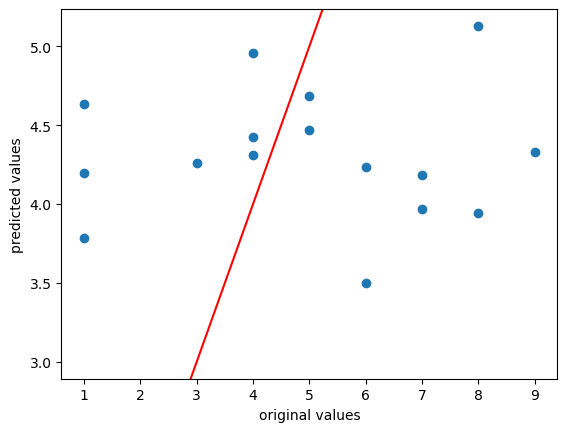

In [15]:
# predicted-vs-actual scatterplot
fig, ax = plt.subplots()
ax.scatter(y1_test, y1_pred)
plt.xlabel("original values")
plt.ylabel("predicted values")
ax.axline((3,3), slope=1, color = 'red')
plt.show()

We can see the mean APE is quite large, and the scatter plot also shows poor prediction results. The ARIMA model may not be a good model for this specific time series, and we'll try to use auto_arima() for some other time series. 

### 5.5.2 Apply auto_arima() for multiple timeseries<a id='5.5.2'></a>

In [16]:
# columns with less than 2% zeros
df.loc[:, (df==0).mean() < 0.02].columns[:40]

Index(['1,BEVERAGES', '1,BREAD/BAKERY', '1,CLEANING', '1,DAIRY', '1,DELI',
       '1,EGGS', '1,FROZEN FOODS', '1,GROCERY I', '1,GROCERY II', '1,MEATS',
       '1,PERSONAL CARE', '1,POULTRY', '1,PREPARED FOODS', '1,SEAFOOD',
       '10,BEVERAGES', '10,BREAD/BAKERY', '10,CLEANING', '10,DAIRY', '10,DELI',
       '10,EGGS', '10,FROZEN FOODS', '10,GROCERY I', '10,MEATS',
       '10,PERSONAL CARE', '10,POULTRY', '10,PREPARED FOODS', '11,AUTOMOTIVE',
       '11,BEVERAGES', '11,BREAD/BAKERY', '11,CLEANING', '11,DAIRY', '11,DELI',
       '11,EGGS', '11,FROZEN FOODS', '11,GROCERY I', '11,GROCERY II',
       '11,LINGERIE', '11,MEATS', '11,PERSONAL CARE', '11,POULTRY'],
      dtype='object')

For multiple timeseries predictions, we choose stores number 1 to 6 and three product families in which the sales has very few zero values.

In [17]:
stores1 = [*range(1, 7, 1)] # No.1-6 stores
families1 = ['BREAD/BAKERY', 'DAIRY', 'GROCERY I']

grp = data.groupby(['store_nbr', 'family'])

df0 = pd.DataFrame()

for s in stores1:
    for f in families1:
        grp_sel = grp.get_group((s, f))
        col_name = str(s)+","+f
        df_temp = pd.DataFrame(grp_sel['sales']).rename(columns={'sales': col_name})
        df0 = pd.concat([df0, df_temp], axis=1)

df0.head(3)

,"1,BREAD/BAKERY","1,DAIRY","1,GROCERY I","2,BREAD/BAKERY","2,DAIRY","2,GROCERY I","3,BREAD/BAKERY","3,DAIRY","3,GROCERY I","4,BREAD/BAKERY","4,DAIRY","4,GROCERY I","5,BREAD/BAKERY","5,DAIRY","5,GROCERY I","6,BREAD/BAKERY","6,DAIRY","6,GROCERY I"
date,,,,,,,,,,,,,,,,,,
2013-01-01,0.000,0.0,0.0,0.000,0.0,0.0,0.000,0.0,0.0,0.000,0.0,0.0,0.000,0.0,0.0,0.000,0.0,0.0
2013-01-02,470.652,579.0,2652.0,523.882,651.0,3870.0,1361.636,1606.0,8463.0,422.537,589.0,4087.0,566.917,414.0,4558.0,689.217,683.0,5535.0
2013-01-03,310.655,453.0,2121.0,321.693,461.0,2640.0,886.184,1377.0,6712.0,273.752,431.0,2824.0,377.887,366.0,3260.0,412.324,542.0,4040.0


In [18]:
df0.index = pd.DatetimeIndex(df0.index).to_period('D')
df0 = df0.resample('1D').mean().ffill()#interpolate()

In [19]:
df0.shape

(1688, 18)

In [20]:
df0.loc[['2014-01-01']] = df0.loc[['2013-12-31']].values
df0.loc[['2015-01-01']] = df0.loc[['2014-12-31']].values
df0.loc[['2016-01-01']] = df0.loc[['2015-12-31']].values
df0.loc[['2017-01-01']] = df0.loc[['2016-12-31']].values

In [21]:
# (df0 == 0).sum(axis=0)
# df0[df0.isin([0]).any(axis=1)]

In [22]:
# Train-Test Split
df1_train = df0[7:n_train] #starting from day 8
df1_test = df0[n_train:]

In [23]:
# N = len(df1.columns)
mAPE = []
df_pred = pd.DataFrame()
df_actual = pd.DataFrame()

for group in df0.columns:
    y_train = df1_train[group]
    y_test = df1_test[group]
    
    model = pm.auto_arima(y_train,                    
                          start_p=0, start_q=0, # minimum p and q
                          max_p=7, max_q=7,     # maximum p and q
                          test='adf',           # use adftest to find optimal 'd'
                          seasonal=True,
                          m=7,                  # seasonality: weekly
                          d=None,               # let model determine 'd' (order of first-differencing)
                          D=None,               # let model determine 'D' (order of the seasonal differencing)
                          trace=True,#False,#   # print status on the fits
                          error_action='ignore',
                          suppress_warnings=True,
                          stepwise=True)
    
    y_pred = model.predict(y_test.shape[0])
    
    APE_y = abs( (y_test - y_pred) / y_test)
    mAPE_y = np.mean(APE_y)
    print(group+' MAPE: '+str(mAPE_y))
    
    mAPE.append(mAPE_y)
    df_pred[group] = y_pred
    df_actual[group] = y_test
    

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(1,0,1)[7] intercept   : AIC=18768.069, Time=1.07 sec
 ARIMA(0,0,0)(0,0,0)[7] intercept   : AIC=20376.139, Time=0.02 sec
 ARIMA(1,0,0)(1,0,0)[7] intercept   : AIC=19037.624, Time=0.85 sec
 ARIMA(0,0,1)(0,0,1)[7] intercept   : AIC=19687.901, Time=0.32 sec
 ARIMA(0,0,0)(0,0,0)[7]             : AIC=24300.562, Time=0.01 sec
 ARIMA(0,0,0)(0,0,1)[7] intercept   : AIC=19719.948, Time=0.23 sec
 ARIMA(0,0,0)(1,0,0)[7] intercept   : AIC=19095.261, Time=0.51 sec
 ARIMA(0,0,0)(2,0,1)[7] intercept   : AIC=20468.049, Time=1.94 sec
 ARIMA(0,0,0)(1,0,2)[7] intercept   : AIC=inf, Time=3.24 sec
 ARIMA(0,0,0)(0,0,2)[7] intercept   : AIC=19440.685, Time=0.61 sec
 ARIMA(0,0,0)(2,0,0)[7] intercept   : AIC=18838.765, Time=1.74 sec
 ARIMA(0,0,0)(2,0,2)[7] intercept   : AIC=inf, Time=2.17 sec
 ARIMA(1,0,0)(1,0,1)[7] intercept   : AIC=19571.489, Time=1.09 sec
 ARIMA(0,0,1)(1,0,1)[7] intercept   : AIC=18946.570, Time=1.16 sec
 ARIMA(1,0,1)(1,0,1)[7] interce

## 5.6 Evaluation<a id='5.6'></a>

### 5.6.1 MAPE<a id='5.6.1'></a>

In [25]:
df_mape = pd.DataFrame()
df_mape['Group'] = df0.columns
df_mape['MAPE'] = mAPE

print("\033[1m"+"Sorted MAPE values:")
df_mape.sort_values(by=['MAPE'])

Sorted MAPE values:


,Group,MAPE
6,"3,BREAD/BAKERY",0.064395
7,"3,DAIRY",0.069354
13,"5,DAIRY",0.070526
16,"6,DAIRY",0.071419
3,"2,BREAD/BAKERY",0.077469
12,"5,BREAD/BAKERY",0.091174
15,"6,BREAD/BAKERY",0.092604
17,"6,GROCERY I",0.099722
8,"3,GROCERY I",0.103344
4,"2,DAIRY",0.112095


In [26]:
print("\033[1m"+"Best 3 MAPE:")
df_best = df_mape.nsmallest(3, 'MAPE')
df_best

Best 3 MAPE:


,Group,MAPE
6,"3,BREAD/BAKERY",0.064395
7,"3,DAIRY",0.069354
13,"5,DAIRY",0.070526


In [27]:
print("\033[1m"+"Worst 3 MAPE:")
df_worst = df_mape.nlargest(3, 'MAPE')
df_worst

Worst 3 MAPE:


,Group,MAPE
0,"1,BREAD/BAKERY",0.261551
2,"1,GROCERY I",0.221870
9,"4,BREAD/BAKERY",0.219449


**The Best MAPE is about 7%, and the Worst MAPE is about 26%.**

### 5.6.2 Scatter plots<a id='5.6.2'></a>

In [28]:
def scatterplots(columns, ncol=None, figsize=(8, 8)):
    if ncol is None:
        ncol = len(columns)
    nrow = int(np.ceil(len(columns) / ncol))
    fig, axes = plt.subplots(nrow, ncol, figsize=figsize, squeeze=False)
    fig.subplots_adjust(wspace=0.25, hspace=0.4)
    for i, col in enumerate(columns):
        ax = axes.flatten()[i]
        ax.scatter(x = df_actual[col], y = df_pred[col], alpha=0.8)
        ax.set(xlabel="Aactual values", ylabel="Predicted values", title=col)
        min_val = min(df_actual[col])
        ax.axline((min_val, min_val), slope=1, color = 'red')    
    nsubplots = nrow * ncol    
    # for empty in range(i+1, nsubplots):
    #     axes.flatten()[empty].set_visible(False)

Upper: Best 3, Lower: Worst 3


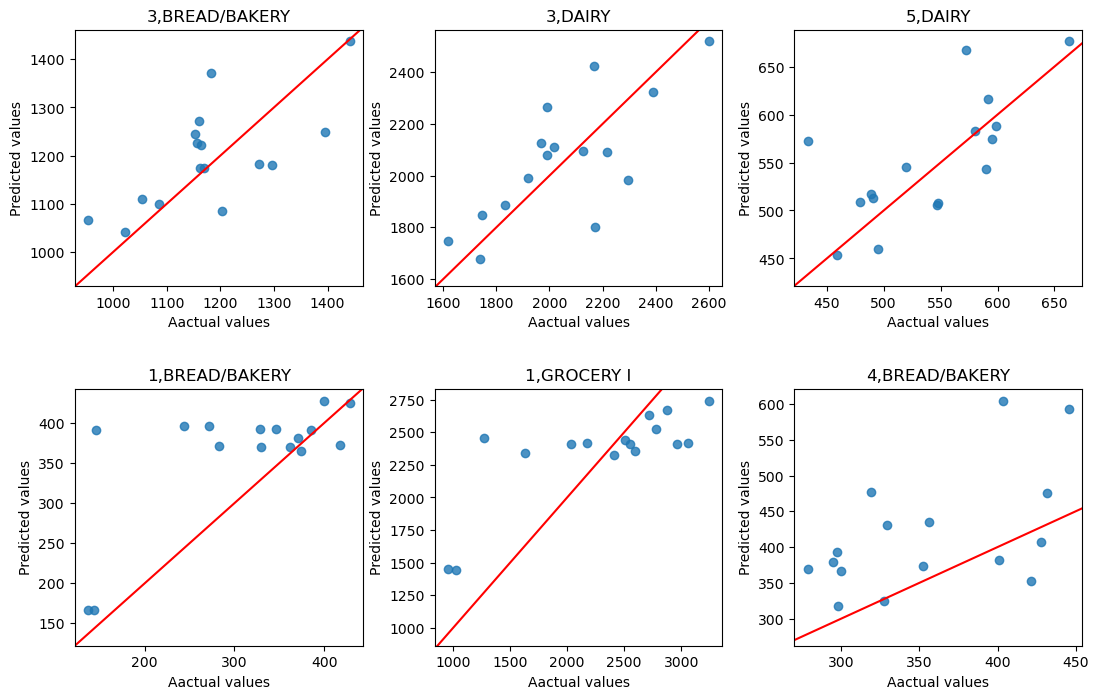

In [29]:
df_comb = pd.concat([df_best, df_worst])
features = df_comb.Group
print("\033[1m"+"Upper: Best 3, Lower: Worst 3")
scatterplots(features, ncol=3, figsize=(13, 8))

**The scatter points in the upper Best 3 plots are closer to the y=x line than those in the lower 3 plots.**

### 5.6.3 Distribution of residuals<a id='5.6.3'></a>

In [30]:
# Residuals
df_resid = df_actual - df_pred
# PEs
df_pe = (df_actual - df_pred) / df_actual

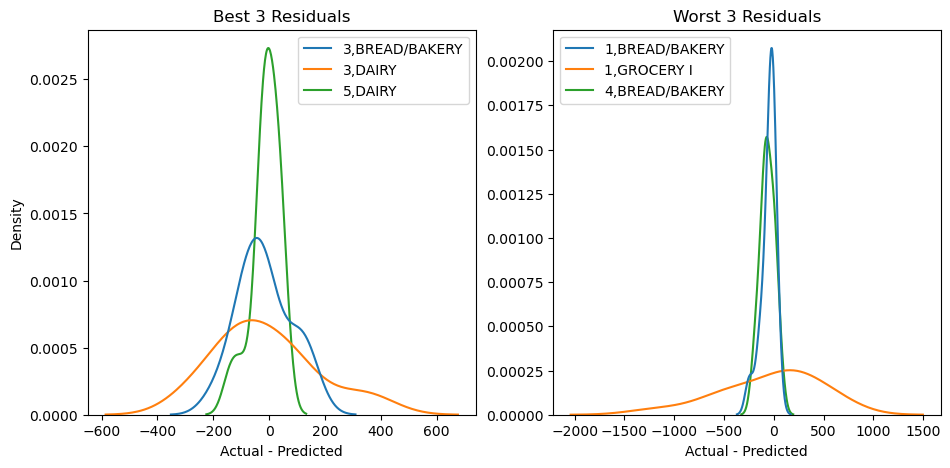

In [31]:
fig, axes = plt.subplots(1, 2, figsize=(11, 5))
sns.kdeplot(ax=axes[0], data=df_resid[df_best.Group])
axes[0].set_title("Best 3 Residuals")
axes[0].set_xlabel("Actual - Predicted")
sns.kdeplot(ax=axes[1], data=df_resid[df_worst.Group])
axes[1].set_title("Worst 3 Residuals")
axes[1].set_xlabel("Actual - Predicted")
axes[1].set_ylabel("")
plt.show()

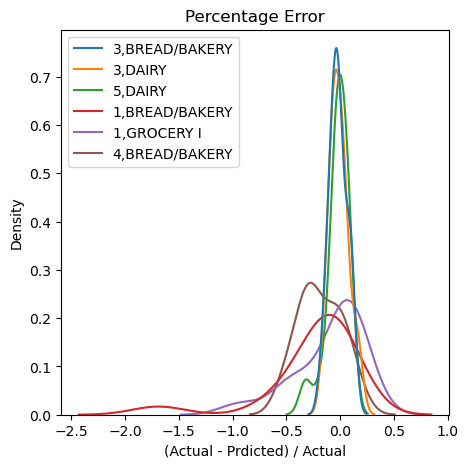

In [32]:
fig, ax = plt.subplots(figsize=(5, 5))
sns.kdeplot(data=df_pe[df_comb.Group])
plt.title("Percentage Error")
plt.xlabel("(Actual - Prdicted) / Actual")
plt.show()

**From the Distribution of Residuals plots, we cannot figure out how the "Best 3" is better than the "Worst 3".\
From the Percentage Error plot, we can clear see that the center lines of the "Best 3" are closer to zero and their distributions are also more concentrated.**

## 5.7 Save Data<a id='5.7'></a>

In [33]:
datapath = '../data'
save_file(df_pred, 'df_pred_1.csv', datapath)
save_file(df_mape, 'df_mape_1.csv', datapath)

Writing file.  "../data/df_pred_1.csv"
Writing file.  "../data/df_mape_1.csv"
